# Embedding Transformed Data

In [33]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime
import os
from glob import glob

from ripser import Rips

import statsmodels.api as sm

# My stuff
from base_config import BaseConfig
from handler import *

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from jupyterthemes import jtplot
jtplot.style(ticks=True, grid=True, gridlines='--')

### Global Parameters and Dataset Prep

In [34]:
print('Available Metrics:\n')
for metric in [x[7:-4] for x in glob('./data/*.csv')]:
    print(metric)

Available Metrics:

Global_reactive_power
Sub_metering_2
Sub_metering_3
Sub_metering_1
Voltage
Global_intensity
Global_active_power


In [35]:
metric = 'Global_intensity'

In [36]:
cfg = BaseConfig(
    dataPath='./data',
    outPath='./out',
    runId='TEST',
    metric=metric,
    minDateData=None,
    maxDateData=None,
    numDaysPred=365,
)

### Clean the data

In [37]:
if metric == 'Global_active_power':
    cfg.patchSeries('2008-08-13', '2008-08-30')

In [38]:
dataset = cfg.dataset

In [39]:
firstDayTrain = '2006-12-16'
firstDayPred = '2010-12-12'

### Plot baseline dataset

In [40]:
dataset['RollingMetric'] = dataset[metric].rolling(7, center=True).mean()

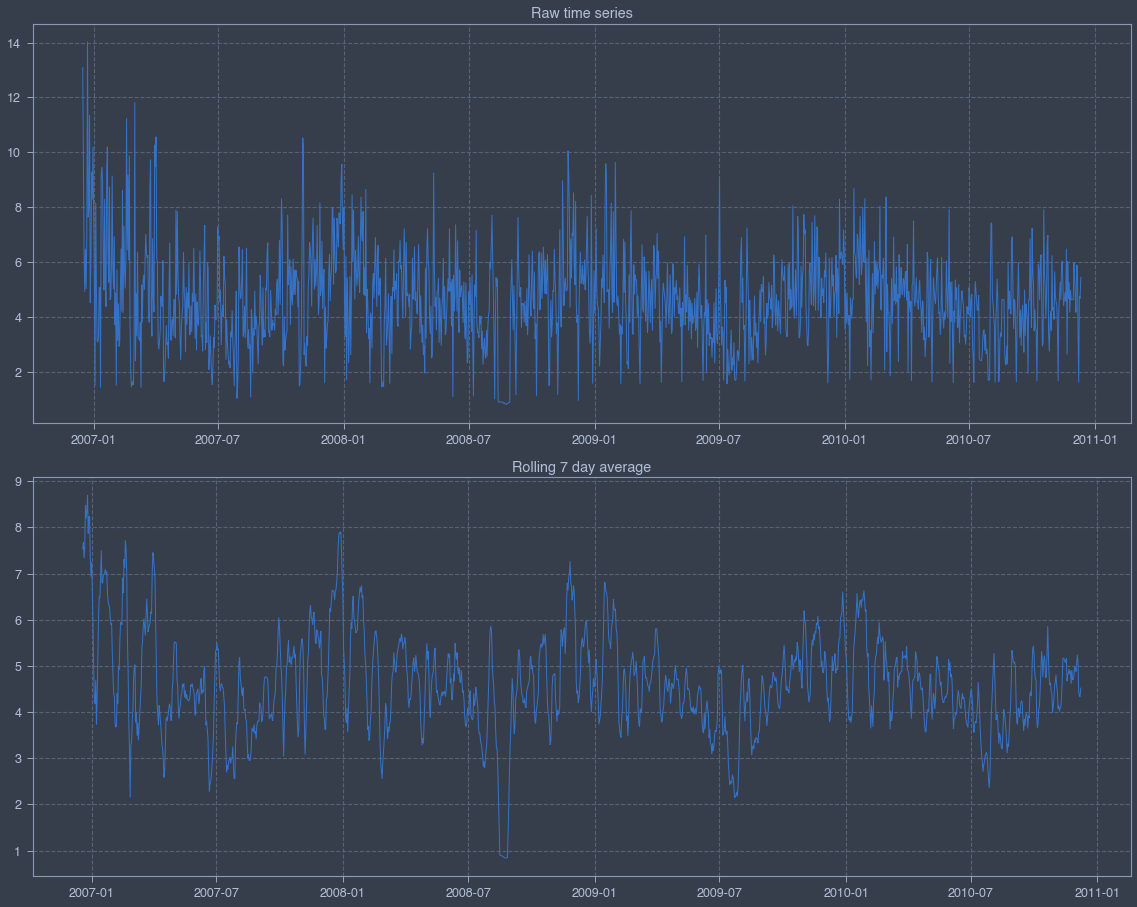

In [41]:
f, axes = plt.subplots(2, 1, figsize=(16, 12.8))
axes[0].plot(dataset.index, dataset[metric], linewidth=1)
axes[0].set_title('Raw time series')
axes[1].plot(dataset.index, dataset['RollingMetric'], linewidth=1)
axes[1].set_title('Rolling 7 day average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Fit Global Trend

In [42]:
Y = dataset['RollingMetric'].loc[firstDayTrain:].dropna()

In [43]:
X = np.arange(0, Y.shape[0])

In [44]:
power = 1.0 # This should never be zero.
XPow = X**power
globalSlope, globalIntercept = np.polyfit(XPow, Y, deg = 1)
G = globalSlope*XPow + globalIntercept

In [45]:
df = pd.DataFrame({
    'x_pow' : XPow,
    'intercept' : 1
})

In [46]:
linear_model = sm.OLS(Y.values, df)
statsLR=linear_model.fit()
print(statsLR.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.019    
Dependent Variable: y                AIC:                4301.0374
Date:               2021-02-01 22:23 BIC:                4311.5974
No. Observations:   1451             Log-Likelihood:     -2148.5  
Df Model:           1                F-statistic:        29.58    
Df Residuals:       1449             Prob (F-statistic): 6.30e-08 
R-squared:          0.020            Scale:              1.1331   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
x_pow          -0.0004    0.0001  -5.4384  0.0000  -0.0005  -0.0002
intercept       4.8844    0.0559  87.4395  0.0000   4.7748   4.9939
------------------------------------------------------------------
Omnibus:               40.331       Durbin-Watson:          0.090 
Prob(Omn

Text(0.5, 1.0, 'Series vs OLS')

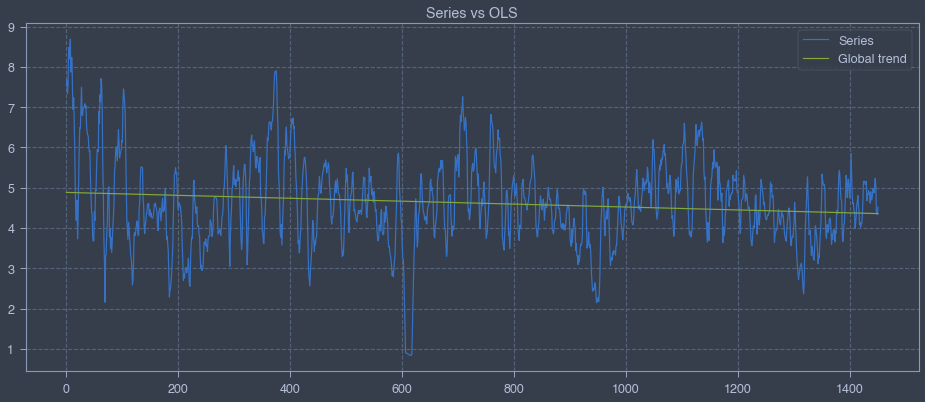

In [47]:
plt.figure(figsize=(16, 6.4))
plt.plot(Y.values, label='Series')
plt.plot(G, label='Global trend')
plt.legend()
#plt.grid(linestyle='dashed')
plt.title('Series vs OLS')

Skipping negative slope for 0-degree 'best fit'.


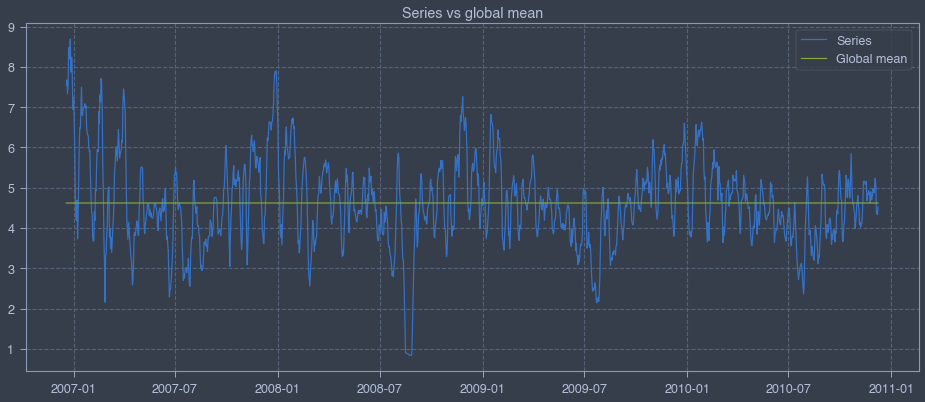

In [48]:
skipOLS = True
if skipOLS:
    print('Skipping negative slope for 0-degree \'best fit\'.')
    fitLinearTrend = pd.Series(Y.mean(), index=Y.index)
    plt.figure(figsize=(16, 6.4))
    plt.plot(Y, label='Series')
    plt.plot(fitLinearTrend, label='Global mean')
    plt.legend()
    #plt.grid(linestyle='dashed')
    plt.title('Series vs global mean')
else:
    fitLinearTrend = pd.Series(G, index=Y.index)

In [49]:
def extrapolateGlobalTrendLinear(numDaysPredict, startDate):
    r""" extrapolate the global trend by `numDaysPredict` days. """

    # Use this value to calculate amount to translate before fitting.
    minDate = fitLinearTrend.index.min()
    xTranslate = (startDate - minDate).days
    X = np.arange(xTranslate, xTranslate + numDaysPredict)

    Xpow = X**power
    globalTrend = globalSlope*Xpow + globalIntercept

    idx = cfg._getDateIndex(minDate=startDate, maxDate=startDate+relativedelta(days=numDaysPredict-1))
    return pd.Series(globalTrend, index=idx)

In [50]:
preExtrapolate = extrapolateGlobalTrendLinear(3, dataset.index.min())
postExtrapolate = extrapolateGlobalTrendLinear(3, fitLinearTrend.index.max()+relativedelta(days=1))

In [51]:
dataset['GlobalTrend'] = pd.concat([preExtrapolate, fitLinearTrend, postExtrapolate])

In [52]:
dataset['DetrendedMetric'] = dataset[metric] - dataset['GlobalTrend']
dataset['DetrendedRolling'] = dataset['RollingMetric'] - dataset['GlobalTrend']

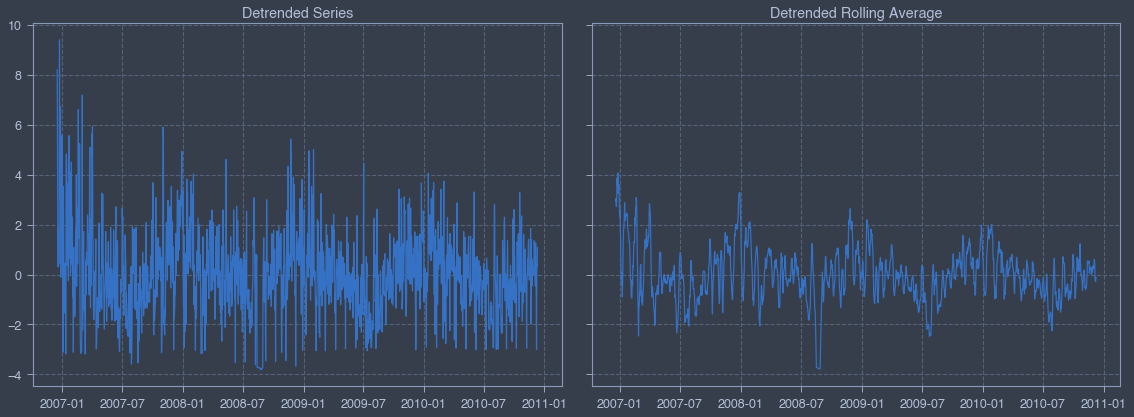

In [53]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset['DetrendedMetric'].loc[firstDayTrain:].dropna())
axes[0].set_title('Detrended Series')
axes[1].plot(dataset['DetrendedRolling'].loc[firstDayTrain:].dropna())
axes[1].set_title('Detrended Rolling Average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Fit Fourier Decomposition

In [54]:
y = dataset['DetrendedRolling'].loc[firstDayTrain:].dropna().loc['2009-01-01' : '2009-12-31']
x = y.index
xs = range(len(y))
z = y # already subtracted best fit

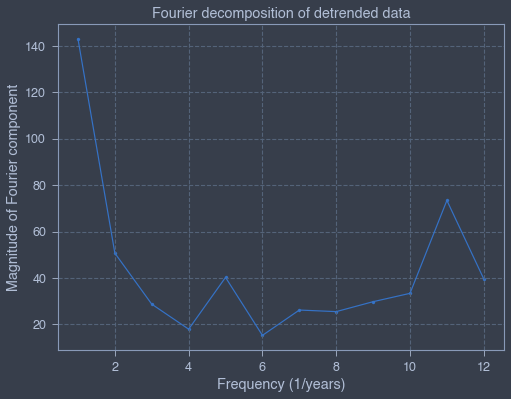

In [55]:
Z = np.fft.fft(z)
plt.figure(figsize=(8,6))
plt.plot(range(1, 13), np.abs(Z[1:13]))
plt.scatter(range(1, 13), np.abs(Z[1:13]), s=10)
plt.xlabel('Frequency (1/years)')
plt.ylabel('Magnitude of Fourier component')
#plt.grid()
_=plt.title('Fourier decomposition of detrended data')

In [56]:
def top_component_filter(Z, i, threshold=12):
    Z_filtered = Z.copy() # necessary to copy?  I don't want any side effects
    
    # kill high frequency components to avoid weekly seasonality dominating
    Z_filtered[range(threshold+1, len(Z_filtered))] = 0
    
    if i > 0:
        # This breaks for i==0, so need the condition
        inds = np.abs(Z_filtered).argsort()[:-i] # indices of all but top i weighted components
        Z_filtered[inds] = 0
    else:
        Z_filtered = np.zeros(Z.shape)
    
    return Z_filtered

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


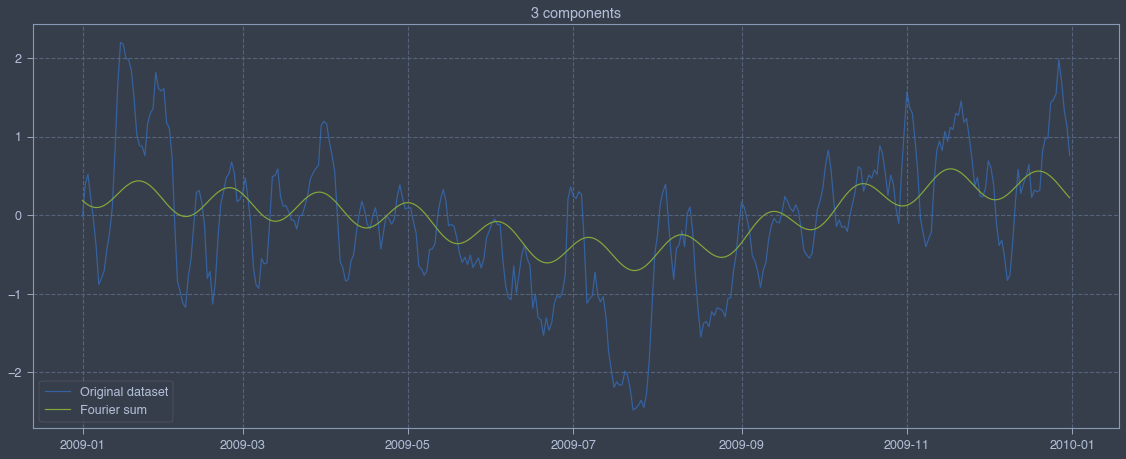

In [57]:
f, ax = plt.subplots(figsize=(16, 6.4))
plt.tight_layout()
num_components = 3
Z = np.fft.fft(z)
Z_filtered1 = top_component_filter(Z, num_components, threshold=12)
ifft1 = np.fft.ifft(Z_filtered1)
ax.plot(x, z, alpha=0.7, label="Original dataset")
ax.plot(x, ifft1, alpha=1, label='Fourier sum')
ax.set_title(str(num_components)+' components')
#ax.grid(linestyle='dashed')
ax.legend()

In [58]:
Z = np.fft.fft(z)
Z_filtered1 = top_component_filter(Z, 3, threshold=12)
ifft1 = np.fft.ifft(Z_filtered1)

In [59]:
df = pd.DataFrame(data={'FourierSum' : ifft1.real}, index=x)

In [60]:
def dateTimeToMonthDay(datetime_index):
    return datetime_index.map(lambda x: x.strftime('%m-%d'))

In [61]:
dataset['tmpMonthDay'] = dateTimeToMonthDay(dataset.index)

In [62]:
df['tmpMonthDay'] = dateTimeToMonthDay(df.index)

In [63]:
dataset = (dataset
           .reset_index()
           .merge(df,
                  left_on='tmpMonthDay',
                  right_on='tmpMonthDay',
                  how='left')
           .set_index('Date')
           .drop('tmpMonthDay', axis=1))

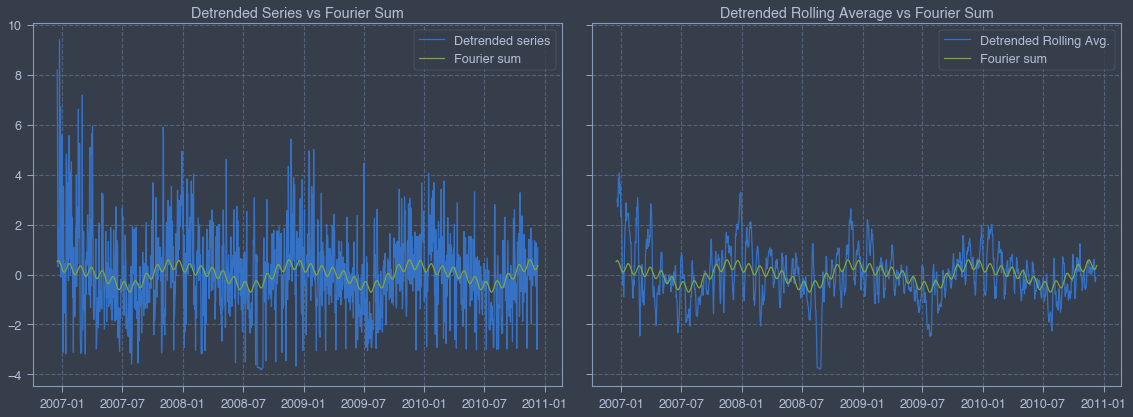

In [64]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'DetrendedMetric'],
             label='Detrended series')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'FourierSum'],
             label='Fourier sum')
axes[0].legend()
axes[0].set_title('Detrended Series vs Fourier Sum')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'DetrendedRolling'],
             label='Detrended Rolling Avg.')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'FourierSum'],
             label='Fourier sum')
axes[1].legend()
axes[1].set_title('Detrended Rolling Average vs Fourier Sum')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

In [65]:
dataset['NonSeasonal'] = dataset['DetrendedMetric'] - dataset['FourierSum']
dataset['NonSeasonalRolling'] = dataset['DetrendedRolling'] - dataset['FourierSum']

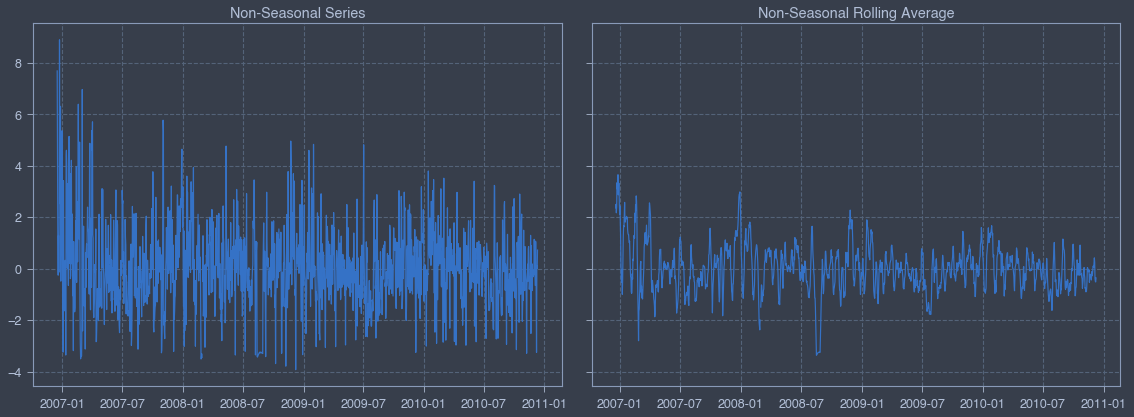

In [66]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'NonSeasonal'])
axes[0].set_title('Non-Seasonal Series')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'NonSeasonalRolling'])
axes[1].set_title('Non-Seasonal Rolling Average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Sliding Window Embedding

In [76]:
tsData = dataset.loc[firstDayTrain:, metric].dropna() # What is plotted above.  One null on 2008-02-29

In [77]:
def slidingWindow(ts, nDim=3):
    r""" Sliding window from (N,)-array to (N - nDim + 1, nDim)-array """
    N = ts.shape[0]
    A = np.zeros((N - nDim + 1, nDim))
    
    for i in range(N - nDim + 1):
        A[i, :] = ts.values[i:i+nDim]
        
    return A

### 3D Plots

In [78]:
nDim = 3
embeddedData = slidingWindow(tsData, nDim=nDim)

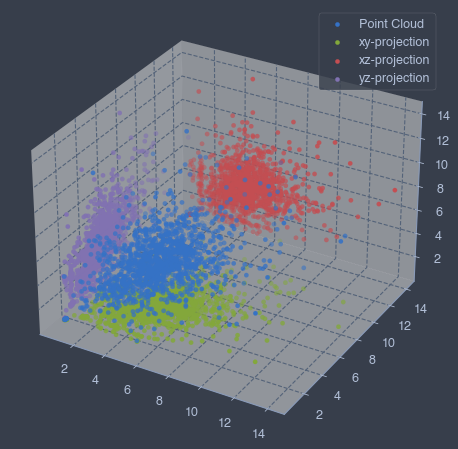

In [80]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(
    embeddedData[:, 0],
    embeddedData[:, 1],
    embeddedData[:, 2],
    label='Point Cloud'
)

ax.scatter(
    embeddedData[:, 0],
    embeddedData[:, 1],
    embeddedData[:, 2].min()*np.ones(embeddedData.shape[0]),
    label='xy-projection'
)
ax.scatter(
    embeddedData[:, 0],
    embeddedData[:, 1].max()*np.ones(embeddedData.shape[0]),
    embeddedData[:, 2],
    label='xz-projection'
)
ax.scatter(
    embeddedData[:, 0].min()*np.ones(embeddedData.shape[0]),
    embeddedData[:, 1],
    embeddedData[:, 2],
    label='yz-projection'
)

ax.legend()

### Persistent Homology of Embedded Data

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


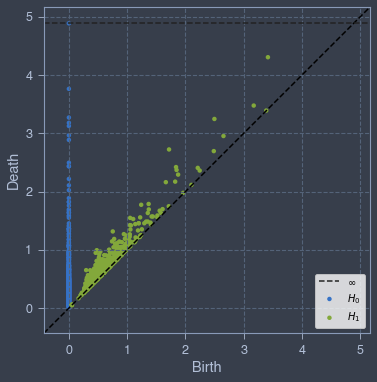

In [81]:
plt.figure(figsize=(10, 6))
rips = Rips(maxdim=1)
diagrams = rips.fit_transform(embeddedData)
rips.plot(diagrams)
jtplot.style(ticks=True, grid=True, gridlines='--')

## Delay Embedding

In [82]:
tsData = dataset['NonSeasonal']

In [83]:
def delayReconstruction(ts, delay=1):
    N = ts.shape[0]
    arr = np.zeros(shape=(N - delay, 2))
    
    for i in range(N - delay):
        arr[i, 0] = ts.values[i]
        arr[i, 1] = ts.values[i + delay]
        
    return arr

Text(0.5, 1.0, 'Delay reconstruction: tau = 14')

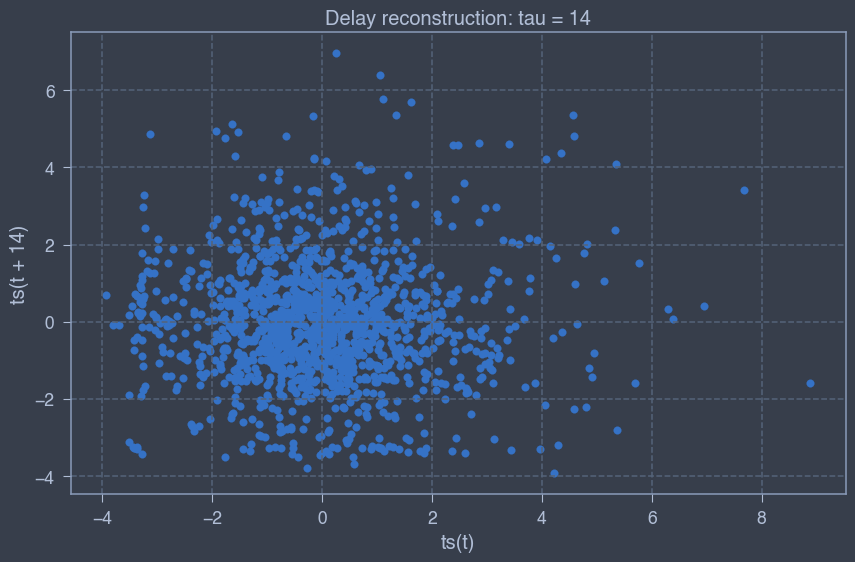

In [87]:
plt.figure(figsize=(10, 6))
tau = 14
delayReconData = delayReconstruction(tsData, delay=tau)
plt.scatter(
    delayReconData[:, 0],
    delayReconData[:, 1],
    #alpha=0.5, s=1
)
plt.xlabel('ts(t)')
plt.ylabel('ts(t + %d)' % tau)
plt.title('Delay reconstruction: tau = %d' % tau)

In [85]:
embeddedData = pd.DataFrame(delayReconData).dropna().values

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


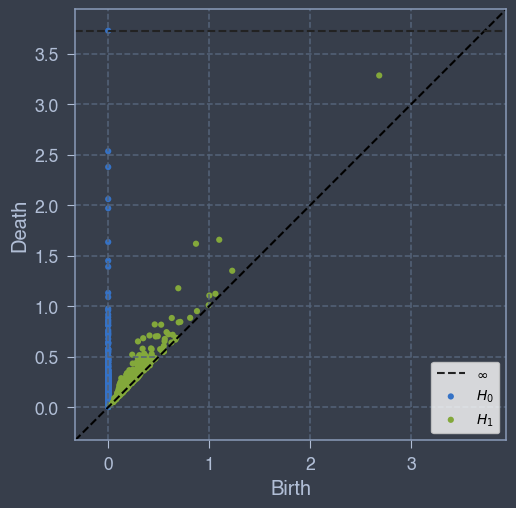

In [86]:
rips = Rips(maxdim=1)
diagrams = rips.fit_transform(embeddedData)
#diagramsSmooth = Rips(maxdim=1).fit_transform(embeddedSmoothedData)
rips.plot(diagrams)
jtplot.style(ticks=True, grid=True, gridlines='--')